# ABCD Method with DNNs

In this tutorial we will learn how to perform an ABCD method by approximating the transfer functions with DNNs.
We will do this in arbitrary dimensions with arbitrarily complex functions.

## Imports, Plotting Functions and Data Creation

In the following cells we will have all necessary imports, define functions for plotting and create the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cycler import cycler

In [2]:
def plot2d(a, b, c, d, weights_d=None):
    d0 = 0
    for d1 in range(1, N_DIMS):
        fig, axs = plt.subplots(2, 2, figsize=(9, 7))
        opts = dict(bins=20, range=[[0, SCALE], [0, SCALE]], density=True)
        axs[1,0].hist2d(a[:, d0], a[:, d1], **opts)
        axs[1,1].hist2d(b[:, d0], b[:, d1], **opts)
        axs[0,0].hist2d(c[:, d0], c[:, d1], **opts)
        h = axs[0,1].hist2d(d[:, d0], d[:, d1], weights=weights_d, **opts)
        fig.colorbar(h[3], ax=axs.flat)
        axs[1,0].set_title("A"), axs[1,1].set_title("B"), axs[0,0].set_title("C"), axs[0,1].set_title("D")
        fig.show() 

We set three key parameters of the task:
- `N_PEAK`: changes the complexity of the functions to scale
- `N_DIMS`: changes the dimensionality of the challenge
- `SCAlE`: changes the size of the underlying distributions

In [3]:
N_PEAK = 5
N_DIMS = 2
SCALE = 10

In [4]:
rng = np.random.default_rng(123)
centers_ac = rng.uniform(0, SCALE, size=(N_PEAK, N_DIMS))
centers_bd = rng.uniform(0, SCALE, size=(N_PEAK, N_DIMS))

In [5]:
def make_samples(centers, n_samples=1_000_000):
    output = []
    for i, center in enumerate(centers):
        output.append(rng.normal(
            loc=center,
            scale=(SCALE + i) / (1 + i),
            size=(n_samples // N_PEAK, N_DIMS)
        ))
    return np.concatenate(output)

Our four regions ABCD have different statistics. Unfortunately our Signal Region (D) has the weakest statistics.
We can to use an ABCD method to improve the statistics in region D.

In [6]:
a = make_samples(centers_ac, 1_000_000)
b = make_samples(centers_bd, 1_000_000)
c = make_samples(centers_ac, 1_000_000)
d = make_samples(centers_bd, 1_000)

Let us first look at the data in the four regions.

We see that the statistics of D is really insufficient.

Fortunately, as the two variables which divide our phase space in the four regions are totally uncorrelated, the transfer factors between A and C and B and D are exactly the same. A perfect use case for the ABCD method.

/var/folders/dw/z8g0cw_s0nzcv0z1jn7vfgsm0000gn/T/ipykernel_94379/1666282047.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


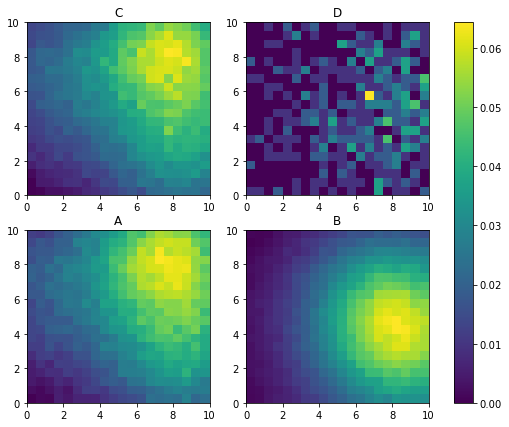

In [7]:
plot2d(a, b, c, d)

## Model Training

We will use a DNN driven classification to measure the ratio (transfer factors) between A and C and apply these transfer factors to C to get a statistically highly enriched region D. First we define a DNN model. The model has a logit output at the end and is trained with the `BinaryCrossentropy` with the option `from_logits=True`. We could also put a sigmoid activation in the last layer of the DNN and use the standard `BinaryCrossentropy` with `from_logits=False`. Mathematically this is exactly the same, however numerically we can run into errors coming from floating point precision.

In [8]:
model = tf.keras.Sequential(
    layers=[
        tf.keras.Input(shape=(N_DIMS,)),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

2022-07-04 11:47:58.818806: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer="adam", loss=bce, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 132,609
Trainable params: 132,609
Non-trainable params: 0
_________________________________________________________________


In [10]:
x = np.concatenate([a, b])
y = np.concatenate([np.ones(len(a)), np.zeros(len(b))])

In [11]:
p = np.random.permutation(len(x))
x, y = x[p], y[p]

In [12]:
model.fit(x=x, y=y, batch_size=1024, epochs=3, validation_split=0.2, verbose=2)

2022-07-04 11:47:59.316387: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/3
1563/1563 - 14s - loss: 0.6583 - accuracy: 0.5845 - val_loss: 0.6554 - val_accuracy: 0.5907
Epoch 2/3
1563/1563 - 13s - loss: 0.6552 - accuracy: 0.5936 - val_loss: 0.6576 - val_accuracy: 0.5992
Epoch 3/3
1563/1563 - 16s - loss: 0.6549 - accuracy: 0.5949 - val_loss: 0.6546 - val_accuracy: 0.5966


## Extract the transfer function
We can now extract the transfer function from C to D as follows:

In [13]:
weights_c_to_d = np.exp(-model.predict(c, batch_size=4096)[:, 0])

## Use the transfer function
We can now use the transfer function extracted above.
We can see that the statistics of the region D is much stronger.

/var/folders/dw/z8g0cw_s0nzcv0z1jn7vfgsm0000gn/T/ipykernel_94379/1666282047.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


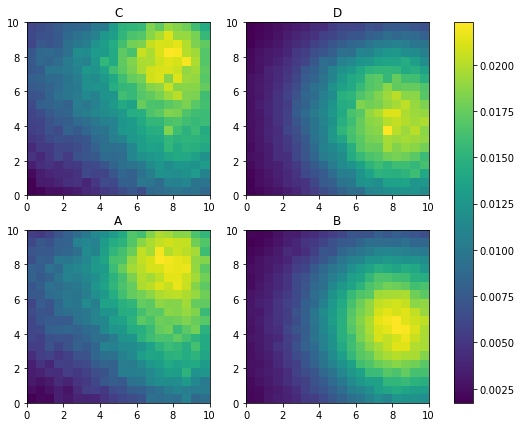

In [14]:
plot2d(a, b, c, d=c, weights_d=weights_c_to_d)

We can also look at the one dimensional projections of the distributions.
Note that the `reweighted` distribution has the same behaviour as distribution `D` but much lower statistical fluctuations.

/var/folders/dw/z8g0cw_s0nzcv0z1jn7vfgsm0000gn/T/ipykernel_94379/3041563622.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/dw/z8g0cw_s0nzcv0z1jn7vfgsm0000gn/T/ipykernel_94379/3041563622.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


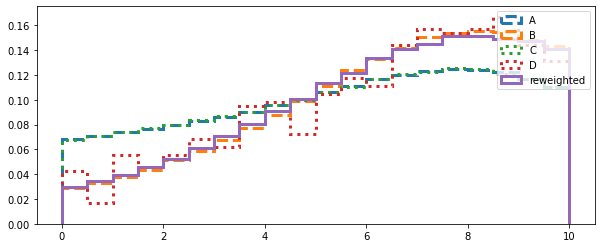

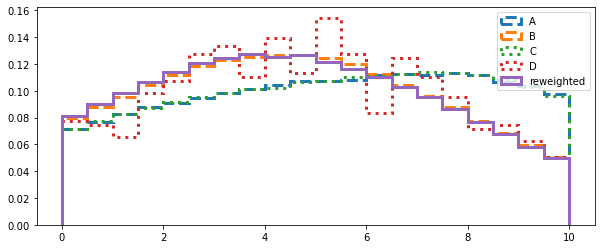

In [15]:
# 1-D projections
for d0 in range(N_DIMS):
    fig, axs = plt.subplots(figsize=(10,4))
    for opts in cycler(
        x=[a, b, c, d, c],
        weights=[None] * 4 + [weights_c_to_d],
        label=["A","B","C","D","reweighted"],
        linestyle=["--", "--", ":", ":", "-"],
    ):
        axs.hist(
            opts.pop("x")[:, d0],
            **opts,
            bins=20,
            range=[0, SCALE],
            density=True,
            histtype="step",
            lw=3,
        )
    axs.legend(loc=0)
    fig.show()

## Task
Now it is your turn, you have seen and understood the working principle of the ABCD method with a DNN based classification. We have done all this in two dimensions and with functions of limited complexity.

Try to find the boundaries of this method:
- What happens for low statistics?
- What happens for many dimensions?
- What happens for very complicated functions? 

## Summary
In this task you have seen how to use DNN based classifications in the ABCD method.

You have learned the following things:
- How to setup a suitable model for this task
- How to train this model
- How to use your model for the scaling
- The improvement this method gives

Additionally you have tested the limitations of this approach.